# Introduction to LIME for explaining classification models
## CHAPTER 04 - *Introduction to LIME for model interpretability*

From **Applied Machine Learning Explainability Techniques** by [**Aditya Bhattacharya**](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/), published by **Packt**

### Objective

In this notebook, let us get familiar with the LIME framework for explaining classification models, based on the concepts discussed in Chapter 4 - Introduction to LIME for model interpretability.

### Installing the modules

Install the following libraries in Google Colab or your local environment, if not already installed.

In [ ]:
!pip install --upgrade pandas numpy matplotlib seaborn scikit-learn lime lightgbm

### Loading the modules

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import lime
import lime.lime_tabular

from lime import submodular_pick

import lightgbm as lgb
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder # For transforming categories to integer labels

In [ ]:
# specify your configurations as a dict
lgb_params = {
    'task': 'train',
    'boosting_type': 'goss',
    'objective': 'binary',
    'metric':'binary_logloss',
    'metric': {'l2', 'auc'},
    'num_leaves': 50,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbose': None,
    'num_iteration':100,
    'num_threads':7,
    'max_depth':12,
    'min_data_in_leaf':100,
    'alpha':0.5}

In [ ]:
# reading the titanic data
df_titanic = pd.read_csv('dataset/titanic_train.csv')
df_titanic.head()

In [ ]:
# data preparation
df_titanic.fillna(0,inplace=True)

le = LabelEncoder()

feat = ['PassengerId', 'Pclass_le', 'Sex_le','SibSp_le', 'Parch','Fare']

# label encoding textual data
df_titanic['Pclass_le'] = le.fit_transform(df_titanic['Pclass'])
df_titanic['SibSp_le'] = le.fit_transform(df_titanic['SibSp'])
df_titanic['Sex_le'] = le.fit_transform(df_titanic['Sex'])


# using train test split to create validation set
X_train,X_test,y_train,y_test = train_test_split(df_titanic[feat],df_titanic[['Survived']],test_size=0.3)


# def lgb_model(X_train,y_train,X_test,y_test,lgb_params):
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)


# training the lightgbm model
model = lgb.train(lgb_params,lgb_train,num_boost_round=20,valid_sets=lgb_eval,early_stopping_rounds=5)



# this is required as LIME requires class probabilities in case of classification example
# LightGBM directly returns probability for class 1 by default 

def prob(data):
    return np.array(list(zip(1-model.predict(data),model.predict(data))))
    


explainer = lime.lime_tabular.LimeTabularExplainer(df_titanic[model.feature_name()].astype(int).values,  
mode='classification',training_labels=df_titanic['Survived'],feature_names=model.feature_name())


# asking for explanation for LIME model
i = 1
exp = explainer.explain_instance(df_titanic.loc[i,feat].astype(int).values, prob, num_features=5)

In [18]:
exp.available_labels()

[0]

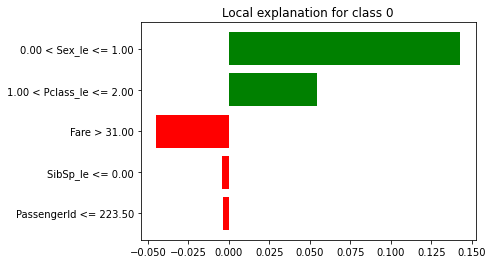

In [19]:
%matplotlib inline
fig = exp.as_pyplot_figure(label = 0);

In [ ]:
exp.show_in_notebook(show_table=True)

In [ ]:
# Code for SP-LIME
import warnings
from lime import submodular_pick

# Remember to convert the dataframe to matrix values
# SP-LIME returns exaplanations on a sample set to provide a non redundant global decision boundary of original model
sp_obj = submodular_pick.SubmodularPick(explainer, df_titanic[model.feature_name()].values, \
prob, num_features=5,num_exps_desired=10)

[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]

[<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>]

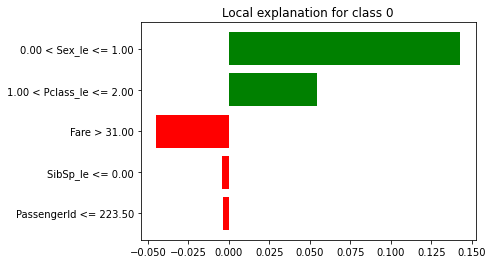

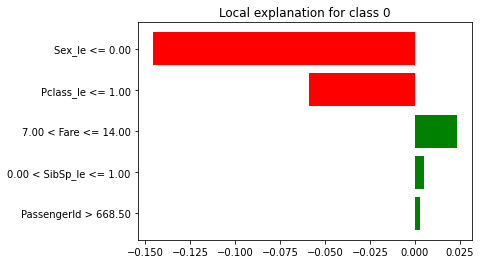

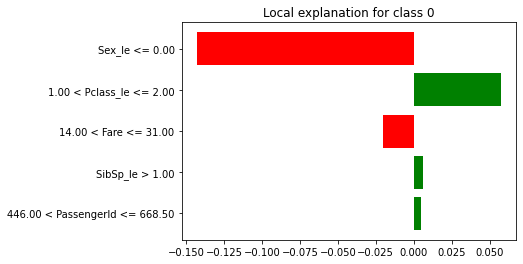

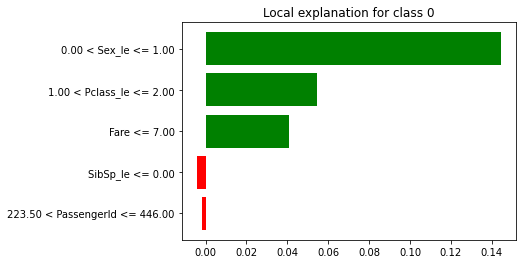

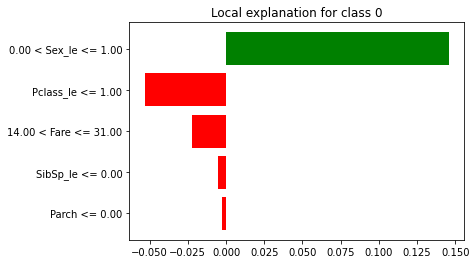

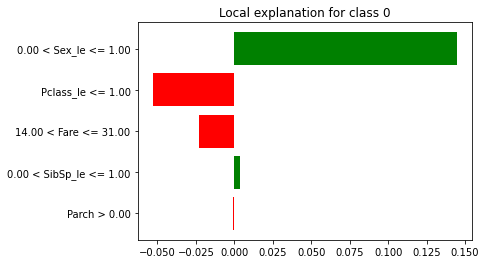

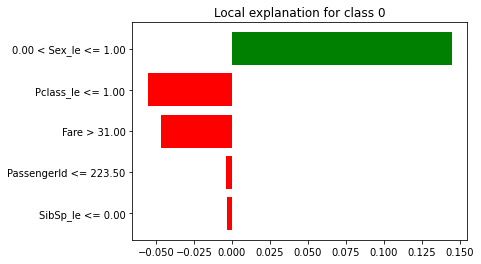

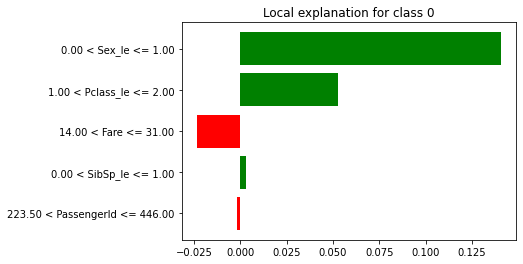

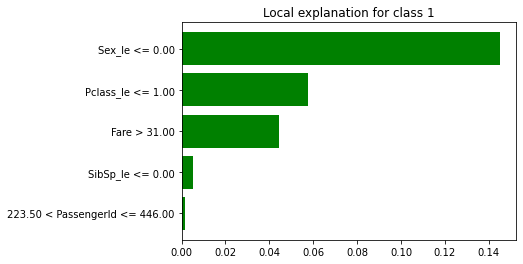

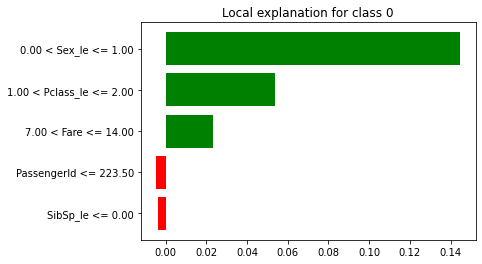

In [21]:
[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations]

In [ ]:
[exp.show_in_notebook() for exp in sp_obj.sp_explanations]

### About the data

**Breast Cancer Wisconsin (Diagnostic) Data Set - UCI Machine Learning Repository**

This dataset is also known as the *breast Cancer* dataset which is used to predict the presence of breast cancer. It is a multivariate dataset used for classification based problems containing 30 different features. More details about this data can be found at - [https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic))

### Loading the data

In [ ]:
data.shape

In [ ]:
data.columns

In [ ]:
data.info()

# Exploring Data-Centric Explainability Approaches

There are many ways to implement the concepts learnt in the chapter. But I felt that [Deepchecks Open Source Python framework](https://deepchecks.com/) is a fantastic library for implementing most of the concepts related to analyzing Data Consistency and Data Purity. The out-of-the-box API methods from the framework enables us to perform these important steps in minimum lines of code. In this notebook, we will utilize the Deepchecks framework on the Breast Cancer Dataset.

In [ ]:
# Let's prepare the datasets and the models
label = 'target'
train_df, test_df = train_test_split(data, test_size=0.2, random_state=123) # Performing an 80-20 split

#Creating Deepchecks object
train = Dataset(train_df, label=label)
test = Dataset(test_df, label=label)

# training and testing dataframes
x_train = train_df.drop(label, axis = 1)
y_train = train_df[label]
x_test = test_df.drop(label, axis = 1)
y_test = test_df[label]

# Model Training
model = RandomForestClassifier()
model.fit(x_train, y_train)

In [ ]:
# Model Evaluation
model.score(x_test, y_test)

Fortunately, we have a very good model with 99% accuracy on the unseen data. We can expect very limited issues related to data purity and consistenyc, but still let us validate using the Deepchecks framework.

# Data Purity Check with Deepcheck's Single Dataset Integrity Suite

In [ ]:
# On the training set
purity_check = single_dataset_integrity()
purity_check.run(train_dataset = train)

In [ ]:
# On the testing set
purity_check.run(test_dataset = test)

As we can observe from the previous step that using just one line we can perform a thorough analysis of the dataset to observe the presence of missing values, duplicates, label ambiguity or any other common data integrity issues. In case if your problem requires frequent usage of any other masure to evaluate the data integrity, I strongly recommend you to reach out to the owners of the framework with a feature request, or even contribute yourself by raising a pull-request and evolve this unified framework.

# Data Consistency Check using Deepchecks

Now, we will use the Train Test Validation Suite to detect the presence of Data Drifts, any Data Distribution issues, Presence of Data Leakage or other data consistency issues between the training and the inference data with minimum lines of code using Deepchecks.

In [ ]:
data_consistency_check = train_test_validation()
data_consistency_check.run(model=model, train_dataset=train, test_dataset=test)

Now this was a very robust check for data Consistency and the report seems to be interesting. The report summary provides us a glimpse of what we need to focus on and what we dont need to focus on. For this particular dataset, our main concern is related to Dominant Feature's Frequency Change, Single Feature's Contribution thus showing high sensitivity due to these features which are also listed in the report. The difference in Predictive Power Score (PPS) between the train and test data, shows some presence of data leakage. But there is no significant presence of feature drift or concept drift. Further analysis can definitely be done on the issues found, but keeping things simple and easy to understand for all level of readers, I will not recommend over analyzing for this use case. I strongly recommend visiting the deepchecks documentatiosn to learn more at: https://docs.deepchecks.com/.  

Next let us review the trust score comparison between the train and test dataset.

### Trust Score Distribution

In [ ]:
trust_score_distribution = TrustScoreComparison(min_test_samples = 100)
trust_score_distribution.run(train, test, model)

# Data Forecastability using Deepchecks Model Evaluation

In [ ]:
data_forecastability_check = model_evaluation()
data_forecastability_check.run(model=model, train_dataset=train, test_dataset=test)

From the model performance check report from Deepchecks, we can inspect the detailed model performance on various metrics used for the classification problem. Custom metrics can also be used to evaluate the data forecastability. Overall, the dataset is good and well curated as it is evident from the good model accuracy on the test data. But we do see the presence of unused features, which otherwise can be neglected if the model accuracy was not good enough.

# Data Profiling

Now, let me show a small demo to perform simple data profiling. Although the dataset has multiple features, we will pick up the top 3 features based on feature importance and create data profiles of the training and test set and compare both the profiles to observe presence of any inconsistency.

In [ ]:
# From the Data Forecastability section, the top three features are as follows:
important_features = ['worst radius', 'mean concave points', 'worst concave points']
data_profiling_train_df = train_df[important_features]
data_profiling_test_df = test_df[important_features]

In [ ]:
data_profiling_train_df.head()

In [ ]:
data_profiling_test_df.head()

Next we will build a very simple data profile using common statistical measures like mean, median and coeficient of variation. The choice of complexity of statistical measures might vary from dataset to dataset and from use case to use case.

In [ ]:
def build_data_profile(df):
    '''
    Method to build statistical data profiles
    '''
    profile_parameter = []
    profile_value = []
    for feature in df.columns:
        # Mean
        profile_parameter.append('mean_'+ feature)
        profile_value.append(np.mean(df[feature]))
        # Median
        profile_parameter.append('median_'+ feature)
        profile_value.append(np.median(df[feature]))
        # Coefficient of Variance
        profile_parameter.append('cov_'+ feature)
        profile_value.append(np.std(df[feature]/np.mean(df[feature])))
     
    data_profile_df = pd.DataFrame([profile_value], columns = profile_parameter)
    return data_profile_df


In [ ]:
train_profile = build_data_profile(data_profiling_train_df)
train_profile

In [ ]:
test_profile = build_data_profile(data_profiling_test_df)
test_profile

In [ ]:
# Calculate absolute percentage change in the DataFrame column values
pct_df = pd.DataFrame(columns = ['Parameter', '% change'])
for col in train_profile.columns:
    pct_dict = {'Parameter' : col, '% change' : np.abs((test_profile[col][0] - train_profile[col][0])/train_profile[col][0] * 100)}
    pct_df = pct_df.append(pct_dict, ignore_index = True)

display(pct_df)                                

From the above table, we can clearly observe that for all statistical measures, the absolute percentage change in the profile values between the train and test set are less than 25%. If the absolute percentage change is more than 20%, this indicates the presence of some data drift in the dataset.

## Final Thoughts

In this notebook, we have learnt how the deepchecks framework can be effectively used to perform data-centric explanability methods. For certain method, if the framework does not support any built-in out-of-the-box api to implement the concept, we can definitely go with our custom approach similar to what we have seen in the Data Profiling section. Overall, detecting issues related to data consistency like data drifts, data leakage, data purity like missing values, duplicate values, outliers, and data forecasting using model evaluation metrics are certain essential measures that provides valuable explainability to our models and algorithms surrounding the underlying dataset.

## Reference

1. UCI Machine Learning Repository -https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)
2. Deepcheck Open Source Python Framework - https://deepchecks.com/
3. Some of the utility functions and code are taken from the GitHub Repository of the author - Aditya Bhattacharya https://github.com/adib0073